In [1]:
import cdms2 as cdms
import MV2 as MV
import cdtime,cdutil,genutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import string
import glob
import scipy.stats as stats
# Local solution
# If running remotely, uncomment the following code:
# %%bash
# git clone https://github.com/katemarvel/CMIP5_tools
# import CMIP5_tools as cmip5
import sys,os
sys.path.append("/Users/kmarvel/Google Drive/python-utils")

import CMIP5_tools as cmip5
import DA_tools
import Plotting

from eofs.cdms import Eof
from eofs.multivariate.cdms import MultivariateEof
%matplotlib inline

computer="laptop"
if computer is "laptop":
    rootdirec="/Volumes/MarvelCMIP6/DROUGHT/"
else:
    rootdirec="/Users/kmarvel/Documents/DATA/"
    
vcert=stats.norm.interval(.99)[1]

#Region locations
NCA4regions={}
#Northwest (NW): (125°W–111°W, 42°N–49°N)
NCA4regions["NW"]=cdutil.region.domain(longitude=(-125,-111),latitude=(42,49))
#Southwest (SW): (124°W–102°W, 31°N–42°N)
NCA4regions["SW"]=cdutil.region.domain(longitude=(-124,-102),latitude=(31,42))
#Upper Great Plains (GPu): (116°W–95°W, 40°N–49°N)
NCA4regions["GPu"]=cdutil.region.domain(longitude=(-116,-95),latitude=(40,49))
#Lower Great Plains (GPl): (107°W–93°W, 26°N–40°N)
NCA4regions["GPl"]=cdutil.region.domain(longitude=(-107,-93),latitude=(26,40))
#Midwest (MW): (97°W–80°W, 36°N–50°N)
NCA4regions["MW"]=cdutil.region.domain(longitude=(-97,-80),latitude=(36,50))
#Northeast (NE): (82°W–67°W, 37°N–48°N)
NCA4regions["NE"]=cdutil.region.domain(longitude=(-82,-67),latitude=(37,48))
#Southeast (SE): (95°W–76°W, 25°N–39°N)
NCA4regions["SE"]=cdutil.region.domain(longitude=(-95,-76),latitude=(25,39))



In [2]:
from DroughtHelper import *

In [3]:
def write_SN():
    variables=['tas', 'mrro', 'mrros', 'mrso', 'mrsos', 'pr', 'evspsbl', 'prsn']
    seasons=["DJF","MAM","JJA","SON"]
    writedirec="/Volumes/MarvelCMIP6/DROUGHT/DroughtSN/"
    for variable in variables:
        for region in NCA4regions.keys():

            print(region)
            X=TOE(variable,region)
            for season in seasons:
                if np.abs(X.average_SN_end_century(season))>vcert:
                    print(season)
                    plt.figure()
                    SN=X.plot_signal_to_noise(season)
                    plt.title(region+ "("+season+")")
                    #plt.savefig(variable+"."+region+"."+season+".SN.png")
                    writehere=writedirec+region+"/"
                    os.system("mkdir "+writehere)
                    for ssp in SN.keys():
                        data=SN[ssp]
                        data.id=variable+"_SN"

                        writefname=variable+"."+ssp+"."+region+"."+season+".SN.nc"
                        fw=cdms.open(writehere+writefname,"w")
                        fw.write(data)
                        fw.close()

In [4]:
def fix_SN():
    for region in NCA4regions.keys():
        cmd="mkdir /Volumes/MarvelCMIP6/DROUGHT/DroughtSN/"+region+"/"
        os.system(cmd)
        snfnames=glob.glob("/Volumes/MarvelCMIP6/DROUGHT/DroughtSNBackup/"+region+"/*")

        variables=np.unique([x.split("/")[-1].split(".")[0] for x in snfnames])
        for variable in variables:

            X=TOE(variable,region)
            missing_data={}
            for tscenario in ["ssp126","ssp245","ssp370","ssp585"]:
                ens_av=X.ensemble_average(tscenario)
                missing_data[tscenario]=ens_av[:,-1].mask
            fixfiles=glob.glob("/Volumes/MarvelCMIP6/DROUGHT/DroughtSNBackup/"+region+"/"+variable+".*")
            for fil in fixfiles:
                f=cdms.open(fil)
                data=f(variable+"_SN")
                scenario=fil.split(".")[1]
                mask=missing_data[scenario]
                if mask.shape is ():
                    data2=data
                else:
                    nmod,nt=data.shape
                    bigmask=np.ma.repeat(mask[:,np.newaxis],nt,axis=1)
                    data2=MV.masked_where(bigmask,data)
                data2.id=data.id

                wfil=fil.replace("Backup","")
                fw=cdms.open(wfil,"w")
                fw.write(data2)
                fw.close()
                f.close()

In [41]:
def plot_correlations(region,season=None,significance_level=None):
#if 1:
    scenario="ssp585"
    droughtdirec="DroughtSN/"
    TRENDS={}
    CLIM={}
    MAXSIG={}
    mysort=["tas","evspsbl","mrros","mrro","mrsos","mrso","pr","prsn"]

    snfiles=glob.glob(rootdirec+droughtdirec+region+"/*")
    variables_match=sorted(np.unique([x.split(".")[0].split("/")[-1] for x in snfiles]))
    for variable in variables_match:
        #print(variable)
        #find the season of max signal
        vfiles=glob.glob(rootdirec+droughtdirec+region+"/*"+variable+".*")
        months = np.unique([x.split(".")[3] for x in vfiles])

        if len(months)==1:
            month_maxsig=months[0]
        else:
            cts=[]
            for month in months:

                ct=get_crossing_time(region,variable,"ssp585",month)
                if ct is None:
                    ct=2101
                cts+=[ct]
            month_maxsig=months[np.argmin(np.array(cts))]
        if season is not None:
            month_maxsig=season
        X=TOE(variable,region)
        ssp585=X.ensemble_average("ssp585")
        historical=X.ensemble_average("historical")
        trends=cmip5.get_linear_trends(getattr(cdutil,month_maxsig).departures(ssp585))
        climatology=getattr(cdutil,month_maxsig).climatology(historical(time=('1980-1-1','2014-12-31')))[:,0]
        TRENDS[variable]=trends
        CLIM[variable]=climatology
        MAXSIG[variable]=month_maxsig


    nvars=len(TRENDS.keys())
    ok_variables=sorted(TRENDS.keys())
    CLIM_CORRS=np.zeros((nvars,nvars))+1.e20
    CLIM_PVALS=np.zeros((nvars,nvars))+1.e20
    
    TREND_CORRS=np.zeros((nvars,nvars))+1.e20
    TREND_PVALS=np.zeros((nvars,nvars))+1.e20
    
    CROSS_CORRS=np.zeros((nvars,nvars))+1.e20
    CROSS_PVALS=np.zeros((nvars,nvars))+1.e20
    
    for variable in ok_variables:
        i=ok_variables.index(variable)
        for v2 in ok_variables:
            j=ok_variables.index(v2)
            #try:
            CLIM_CORRS[i,j]=stats.pearsonr(CLIM[variable],CLIM[v2])[0]
            CLIM_PVALS[i,j]=stats.pearsonr(CLIM[variable],CLIM[v2])[1]
            TREND_CORRS[i,j]=stats.pearsonr(TRENDS[variable],TRENDS[v2])[0]
            TREND_PVALS[i,j]=stats.pearsonr(TRENDS[variable],TRENDS[v2])[1]
            CROSS_CORRS[i,j]=stats.pearsonr(CLIM[variable],TRENDS[v2])[0]
            CROSS_PVALS[i,j]=stats.pearsonr(CLIM[variable],TRENDS[v2])[1]
           # except:
             #   print((variable,v2))
               # continue
    xlabels=[]
    for variable in TRENDS.keys():
        if variable in MAXSIG.keys():

            xlabels+=[MAXSIG[variable]+" "+variable]
        else:
            xlabels+=[variable]
   
    diag_mask =  np.tri(TREND_CORRS.shape[0], k=-1)
    CLIM_CORRS=np.ma.masked_where(CLIM_CORRS>1.e10,CLIM_CORRS)
    if significance_level is not None:
        CLIM_CORRS=np.ma.masked_where(CLIM_PVALS>significance_level,CLIM_CORRS)

    CROSS_CORRS=np.ma.masked_where(CROSS_CORRS>1.e10,CROSS_CORRS)
    if significance_level is not None:
        CROSS_CORRS=np.ma.masked_where(CROSS_PVALS>significance_level,CROSS_CORRS)

    TREND_CORRS=np.ma.masked_where(TREND_CORRS>1.e10,TREND_CORRS)
    if significance_level is not None:
        TREND_CORRS=np.ma.masked_where(TREND_PVALS>significance_level,TREND_CORRS)
    fig=plt.figure(figsize=(12,5))
    ax1=plt.subplot(1,3,1)
    plt.pcolor(np.ma.array(CLIM_CORRS,mask=diag_mask),vmin=-1,vmax=1,cmap=cm.RdBu)
    plt.xticks(np.arange(nvars)+.5,xlabels,fontsize=8,rotation="vertical")
    plt.yticks(np.arange(nvars)+.5,xlabels,fontsize=8)
    plt.xlabel("climatology")
    plt.ylabel("climatology")
    plt.colorbar(orientation="horizontal")
    ax1.xaxis.tick_top()

    ax2=plt.subplot(1,3,2)
   
    plt.pcolor(np.ma.array(TREND_CORRS,mask=diag_mask),vmin=-1,vmax=1,cmap=cm.RdBu)
    plt.xticks(np.arange(nvars)+.5,xlabels,fontsize=8,rotation="vertical")
    plt.yticks(np.arange(nvars)+.5,xlabels,fontsize=8)
    plt.xlabel("trend")
    plt.ylabel("trend")
    plt.colorbar(orientation="horizontal")
    ax2.xaxis.tick_top()
    ax3=plt.subplot(1,3,3)
    plt.pcolor(np.ma.array(CROSS_CORRS,mask=diag_mask),vmin=-1,vmax=1,cmap=cm.RdBu)
    plt.xticks(np.arange(nvars)+.5,xlabels,fontsize=8,rotation="vertical")
    plt.yticks(np.arange(nvars)+.5,xlabels,fontsize=8)
    plt.xlabel("climatology")
    plt.ylabel("trend")
    plt.colorbar(orientation="horizontal")
    ax3.xaxis.tick_top()
    plt.tight_layout()

# OVERVIEW
For each region, we begin by investigating multi-model mean changes over the annual cycle in eight hydroclimate variables: near-surface air temperature (tas), evaporation (evspsbl), surface (mrros) and total (mrro) runoff, surface (mrsos) and column-integrated (mrso) soil moisture.  Evaporation, precipitation, and runoff are reported in units of mm/day and soil moisture changes in units of kg/m2.  

We calculate monthly average trends for each year 2015-2100 inclusive in the (debatably plausible) "worst-case scenario" SSP5-8.5, corresponding to a projected top-of-atmosphere energy imbalance of 8.5 W/m2 by the end of the twenty-first century.  The multi-model mean is calculated first by averaging first over all members of a single model ensemble, and then by taking the average over different models.  For all analyses, we use only models that have provided all eight hydroclimate variables for the historical and pre-industrial control experiments as well as at least two of four scenarios: the "aggressive mitigation" scenario SSP1-2.6, the "committed mitigation" scenario SSP2-4.5, the moderately high forcing scenario  SSP3-7.0, and SSP5-8.5.  These models are listed in Table 1.

We also report inter-model differences in trends over the annual cycle in each of these variables.  To calculate these, we use the full ensemble of SSP5-8.5 simulations for each model and report ensemble average trends.  Because these ensembles are not of uniform size, internal variability plays a different role in different models: it is substantially damped in models that provided large ensembles to the CMIP6 archive, while forced trends in models with only a single ensemble member could be more affected by internal variability.  Still, instead of imposing a uniform ensemble size, we rely on the large forcing and long timescales to be confident that each reported trend is representative of that model's forced trend. 

However, projected changes must be evaluated against the backdrop of internal climate variability.  Even large trends may not represent a detectable departure from normal if multidecadal internal variability is substantial.  We therefore evaluate the multi-model mean signal emergence time, defined as the year at which the projected trend exceeds climate noise at the 99\% confidence level. This value is inherently dependent on start date; we choose 1980 as the start time because many observational and reanalysis datasets begin at that time.  Noise is defined using the pre-industrial control simulations from each model.  We concatenate seasonal anomalies together to form one long time series and define the noise term to be the standard deviation of the distribution of all possible L-length trends.  

Finally, to understand inter-model differences and relationships between variables, we calculate correlations between the model seasonal climatologies of the eight variables, forced trends in these variables under the SSP5-8.5 scenario, and cross-correlations between climatologies and trends.  For visual clarity, we calculate trends and climatologies only for the season in which the signal is projected to emerge earliest.



# Northwest
In the Pacific Northwest, temperatures are projected to increase throughout the year, while   precipitation remains relatively unchanged except for slight increases in the cold season. Evaporation is projected to increase slightly in all but the summer months, with peak evaporation occuring earlier in this future scenario.  The displacement of peak evaporation relative to peak temperature suggests a role for earlier vegetation springtime growth, and thus increased evapotransipiration in this scenario.  The amount of precipitation falling as snow decreases throughout the months in which, historically, snow has fallen.   Surface runoff robustly decreases in springtime due to decreases in snowmelt; total runoff also decreases during this time but increases in DJF due to increases in rainfall relative to snow.  The total soil moisture content increases in the winter and spring, whereas the surface soil moisture content decreases throughout the year. 

/Users/kmarvel/anaconda2/envs/cdatpy3/lib/python3.6/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]


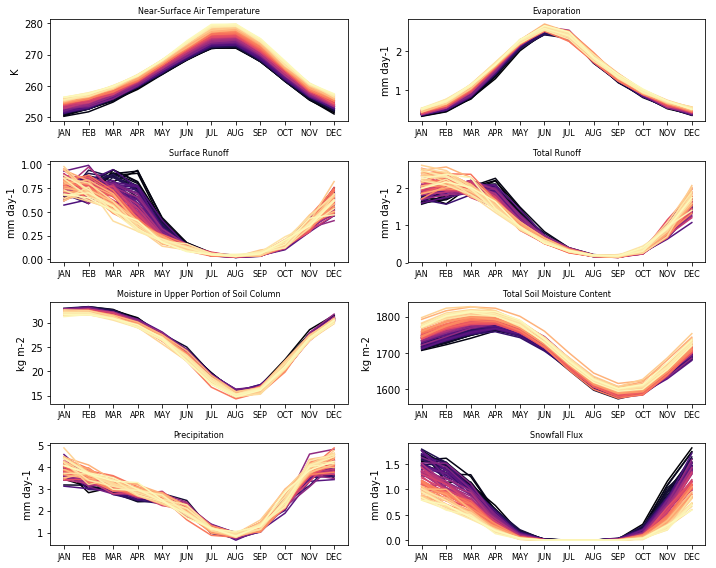

In [6]:
fig,axes=plot_variables("NW")

What are the important inter-model differences in the trends in each of these variables?  Figure XX reveals that, as expected (and as found for every region in this analysis, and therefore not mentioned elsewhere below) the temperature increases in every month, and in every model.  Every model but one projects increases in surface evaporation in winter, spring, and fall; model trends in summertime evaporation are far more uncertain.  While models tend to agree on springtime runoff changes, they disagree throughout the year on the magnitude and even sign of soil moisture trends.

/Users/kmarvel/anaconda2/envs/cdatpy3/lib/python3.6/site-packages/numpy/ma/core.py:3206: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mout = _mask[indx]


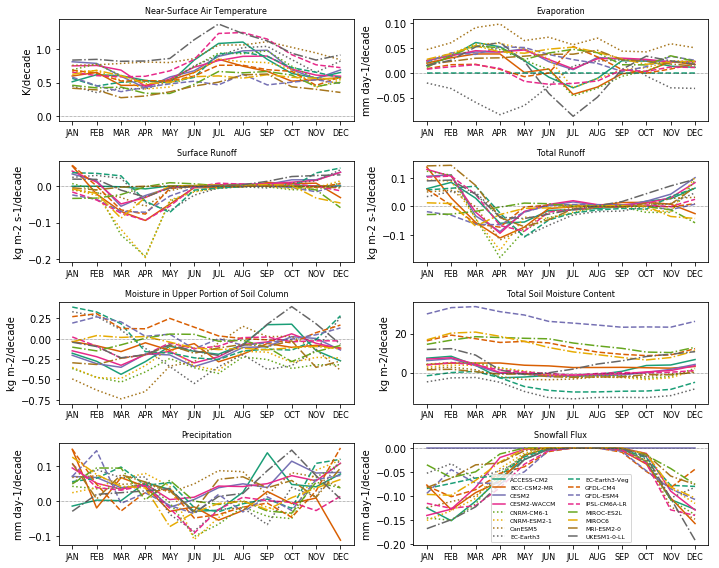

In [7]:
fig,axes=plot_models("NW")

How significant are these trends against the background of natural variability?  Given a start date of 1980, when do we expect the regional signal to emerge from the backdrop of internal climate "noise"?  Figure 2 shows the time of emergence for regional signals in all variables in four scenarios: SSP1-2.6, SSP2-4.5, SSP3-7.0 and the "worst-case" scenario SSP5-8.5.  Only variables for which the S/N ratio exceeds the 99% "virtually certain" level by 2100 in SSP5-8.5 are shown.  In cases where the S/N ratio meets this criteria in multiple seasons, only the season in which it is most dominant is shown. 

Assuming data that begins in 1980, the models project that regardless of scenario, a forced temperature signal (ie, warming) should already be apparent, regardless of scenario.  Increased springtime evaporation, decreases in autumn snowfall, and decreases in springtime surface runoff are not projected to yet be detectable above internal variability at the "virtually certain" 99% confidence level, but they are projected to emerge so soon that differences between mitigation scenarios do not affect their emergence time.  By contrast, signals like increased wintertime precipitation and reductions in springtime surface soil moisture depend strongly on scenario, with the former becoming detectable only under the high-emissions SSP5-8.5 scenario and the latter avoidable only in the high-mitigation SSP1-2.6 scenario.

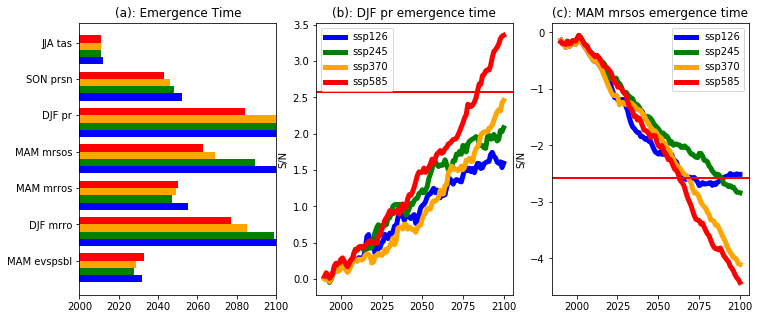

In [8]:
plt.figure(figsize=(12,5))
ax1=plt.subplot(131)
scenario_bar("NW",ax=ax1)
ax1.set_title("(a): Emergence Time")
ax2=plt.subplot(132)
ax2.set_title("(b): DJF pr emergence time")
ax2.set_ylabel("S/N")
plot_all_scenarios("NW","pr","DJF")
ax3=plt.subplot(133)
ax3.set_title("(c): MAM mrsos emergence time")
ax3.set_ylabel("S/N")
plot_all_scenarios("NW","mrsos","MAM")

#scenario_bar("NW",backup=True,ax=ax2)

The differences between scenarios are negligible or nonexistent for temperature, snow cover, springtime surface runoff and evaporation, with relatively early signal emergence regardless of emissions scenario.  For other variables, chiefly springtime surface soil moisture and winter total runoff, aggressive mitigation (as reflected by the SSP1-2.6 scenario) can prevent the emergence of a signal before the end of the century.

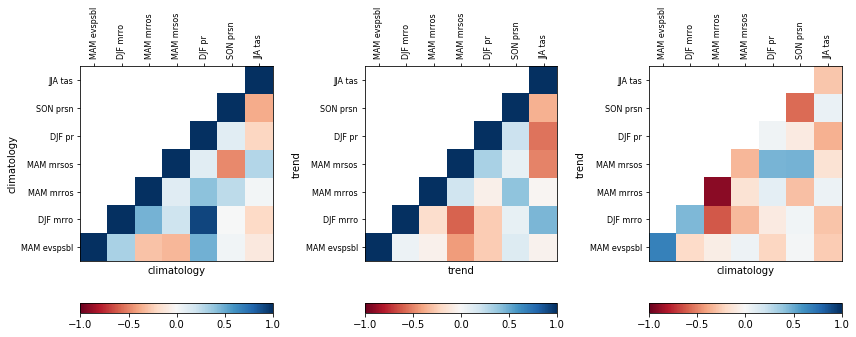

In [9]:
plot_correlations("NW")

Figure XX shows inter-model correlations between the variables and seasons shown in Figure XX: between (a) 1951-1980 historical climatologies of these variables, (b) between 2014-2100 trends in the SSP5-8.5 scenario, and (c) the cross-correlations between climatologies and trends. Figure (a) demonstrates that models with higher wintertime precipitation climatologies tend to have higher climatological values of winter total soil moisture and springtime total evaporation.  Springtime soil moisture and fall snow cover are inversely related (not shown: because fall and spring snowfall climatologies are highly correlated and because the more a model precipitates snow as opposed to rain in the springtime, the drier springtime soil moisture will be).  Figure (b) indicates that peak seasonal warming trends are inversely correlated with trends in wintertime precipitation and MAM surface soil moisture: the more a model warms, the less its winter precipitation decrease and the less severe its springtime soil moisture drying.  Likely for the same reason, warming is positively correlated with total wintertime runoff increases.  Figure (c) shows that 
springtime surface runoff trends are highly negatively correlated with springtime surface runoff climatologies: models with more moisture to lose, lose more.  The same is true for autumn snowfall.  

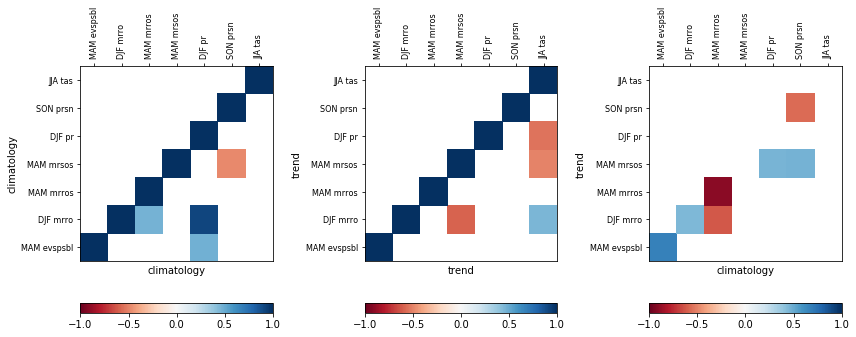

In [40]:
plot_correlations("NW",significance_level=0.1)

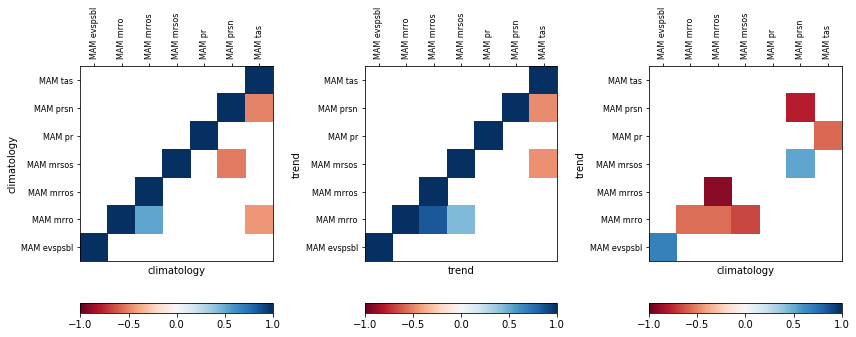

In [42]:
plot_correlations("NW",season="MAM",significance_level=0.1)

# Southwest
In the Southwest, the multi-model average projects a decrease in total evaporation in May and June and no change or slight increases in other months.   Surface and total runoff decreases sharply outside the summer months, as does surface soil moisture.    There are no robust trends in multi-model mean precipitation in any season.

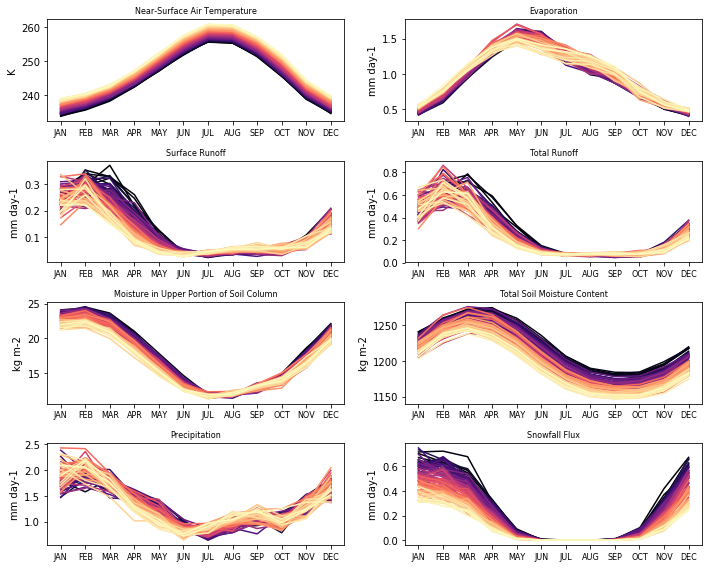

In [10]:
fig,axes=plot_variables("SW")

As in the Northwest region, there are areas of general agreement between models, but also large uncertainties.  Most models project a decrease in total evaporation in May and June, and most show large reductions in springtime surface runoff (the exception here beung UKESM-1-0-LL, which shows increases in runoff and soil moisture throughout the year, along with large increases in rainfall between June and November).  Model disagreement is particularly pronounced in total soil moisture content [WHY?].

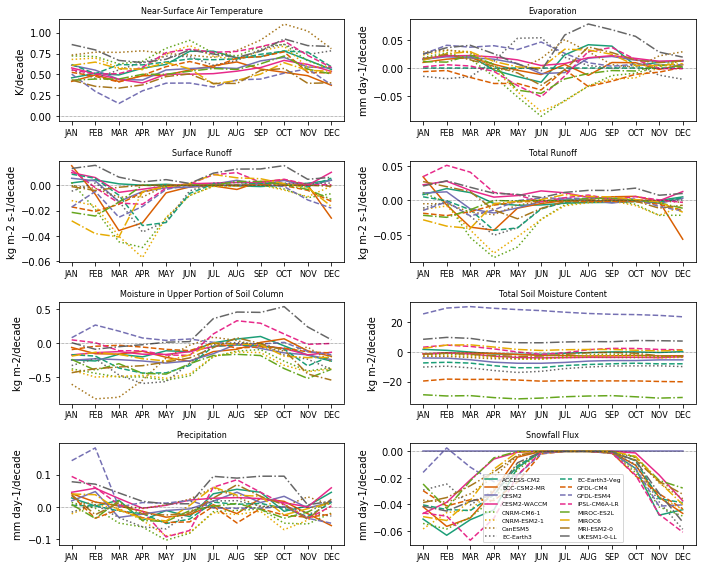

In [11]:
fig,axes=plot_models("SW",change_units=False)

In [12]:
#which is the outlier model?
X=TOE("pr","SW")
ssp585=X.ensemble_average("ssp585")
cdutil.setTimeBoundsMonthly(ssp585)
jan_trends=cmip5.get_linear_trends(cdutil.JAN.departures(ssp585))
cmip5.models(ssp585)[np.argmax(jan_trends)]

'GFDL-ESM4'

As in the Northwest, scenario matters greatly for some variables (ie, signal emergence of springtime surface soil moisture drying and runoff decrease is indefinitely delayed in the low-emission SSP1-2.6 scenario) but not others (increases in wintertime   Interestingly, the multi-model mean suggests the springtime decrease in total evaporation is not detectable by 2100 even in the SSP5-8.5 scenario, but the increase in wintertime evaporation is projected to become detectable in the next two decades irrespective of scenario.  

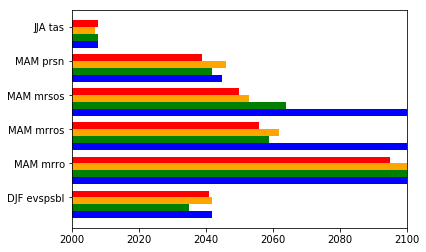

In [13]:
scenario_bar("SW")

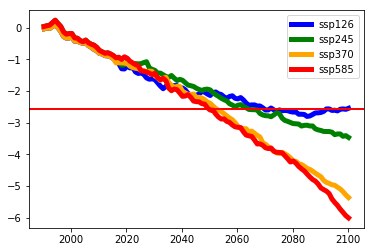

In [14]:
plot_all_scenarios("SW","mrsos","MAM")

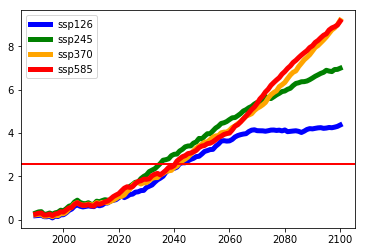

In [45]:
plot_all_scenarios("SW","evspsbl","DJF")

Figure (a) shows that models with climatological warmer summers tend to have smaller springtime snowfalls, and springtime surface and total runoff and surface soil moisture climatologies are positively correlated.  The same holds true for trends: models that warm more in the summer tend to reduce snowfall in the spring, and the changes in springtime surface/total runoff and surface soil moisture are positively correlated.  As for the Northwest, there are strong negative relationships between springtime soil moisture, runoff, and snowfall climatologies and trends.  Surprisingly, there is a strong negative correlation between JJA temperature climatology and JJA warming in this region.

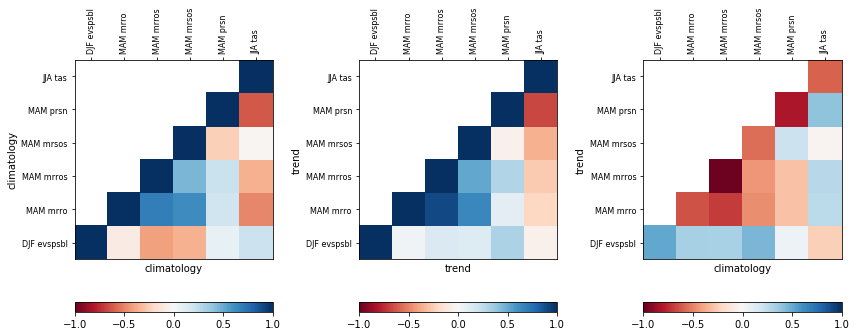

In [16]:
plot_correlations("SW")

/Users/kmarvel/anaconda2/envs/cdatpy3/lib/python3.6/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/Users/kmarvel/anaconda2/envs/cdatpy3/lib/python3.6/site-packages/numpy/ma/core.py:3206: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mout = _mask[indx]


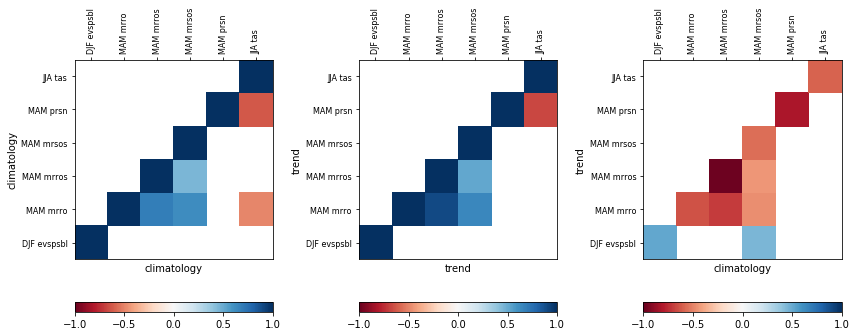

In [46]:
plot_correlations("SW",significance_level=0.1)

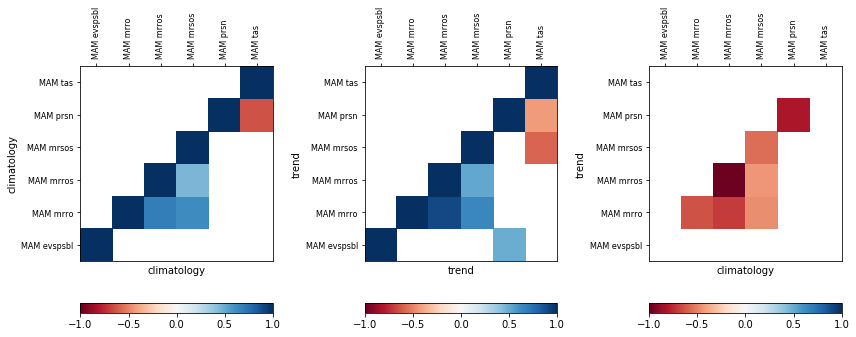

In [47]:
plot_correlations("SW",significance_level=0.1,season="MAM")

# Upper Great Plains
Models project large decreases in surface and total runoff in spring, and smaller increases in winter. While surface soil moisture decreases throughout the year, a seasonal shift in total soil moisture content is apparent, with little change Jan-April and a decrease in May-December. Peak precipitation shifts earlier in the spring, and robust precipitation increases in late winter and early spring are perhaps responsible for the seasonality of the total soil moisture changes.  But while the magnitude of springtime total runoff trend is larger, the increase in winter is more significant against background variability.  In this region, surface soil moisture changes depend heavily on the scenario, with the emergence of an anthropogenic signal delayed infefinitely in SSP1-2.6.  

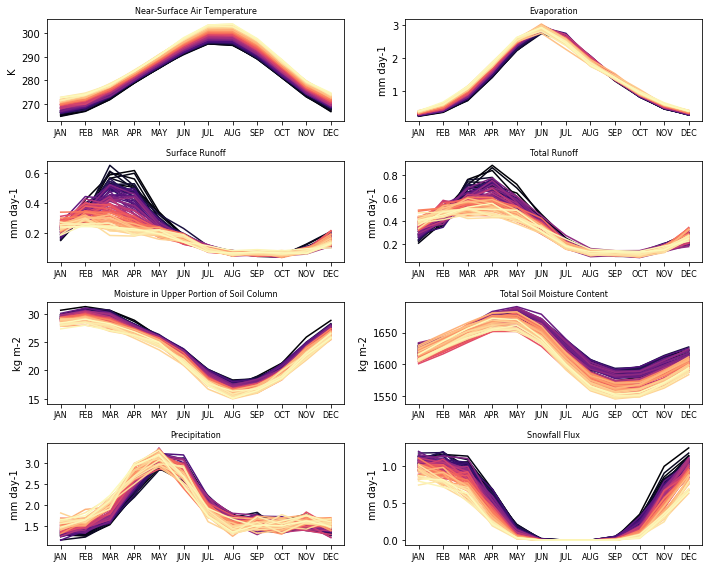

In [17]:
fig,axes=plot_variables("GPu")

Figure XX shows, however, that while these early-season precipitation changes are extremely robust across models, total soil moisture content changes are highly uncertain.  

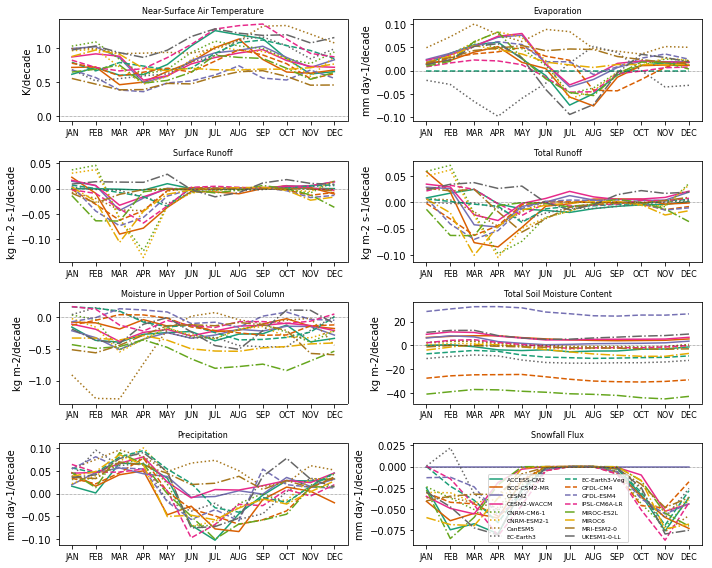

In [18]:
fig,axes=plot_models("GPu",change_units=False)

Figure XX shows the projected signal emergence time for each variable.  Signal emergence is delayed or avoided in heavy mitigation scenarios for springtime surface soil moisture and total runoff, while the signal of decreasing autumn snowfall, increasing springtime precipitation and evaporation and decreasing surface runoff are projected to become detectable regardless of scenario.

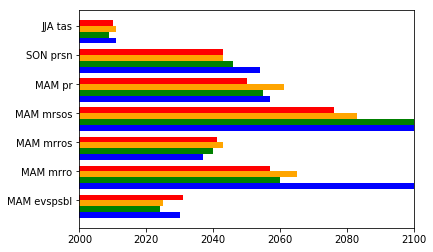

In [19]:
scenario_bar("GPu")

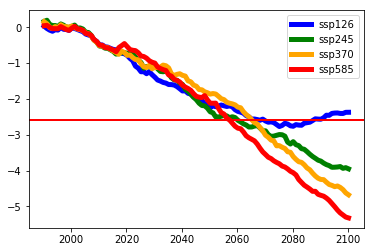

In [20]:
plot_all_scenarios("GPu","mrro","MAM")

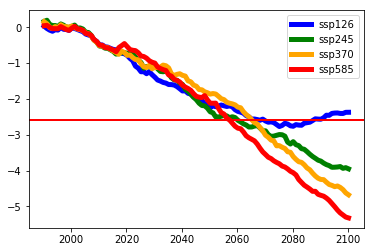

In [21]:
plot_all_scenarios("GPu","mrro","MAM")

Figure XXa shows that warm models have less snow, models with less snow have lower springtime soil moisture, and models with a great deal of springtime surface runoff also tend to have large values of total runoff.  As shown in Figure XXb, models that warm more tend to have larger snowfall reductions and larger reductions in springtime total soil moisture, and models with larger MAM precipitation and evaporation increases have smaller surface soil moisture decreases. As in other western regions, reductions in soil moisture, runoff, and snowfall are largest in models with climatologically large values of these variables.

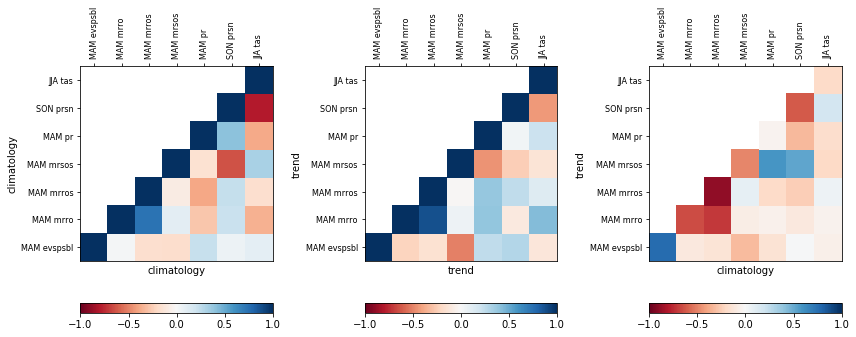

In [22]:
plot_correlations("GPu")

/Users/kmarvel/anaconda2/envs/cdatpy3/lib/python3.6/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/Users/kmarvel/anaconda2/envs/cdatpy3/lib/python3.6/site-packages/numpy/ma/core.py:3206: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mout = _mask[indx]


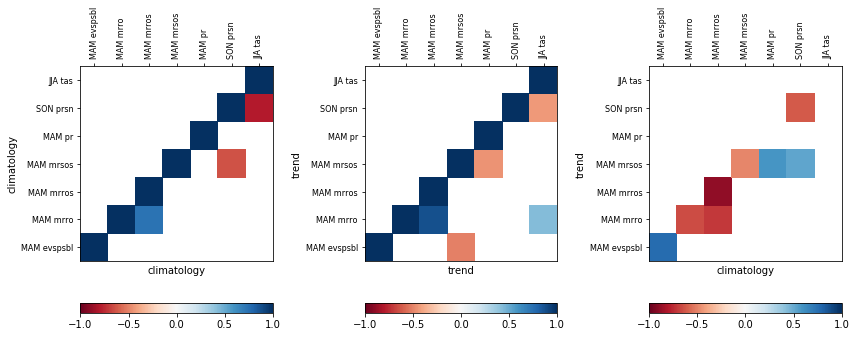

In [48]:
plot_correlations("GPu",significance_level=0.1)

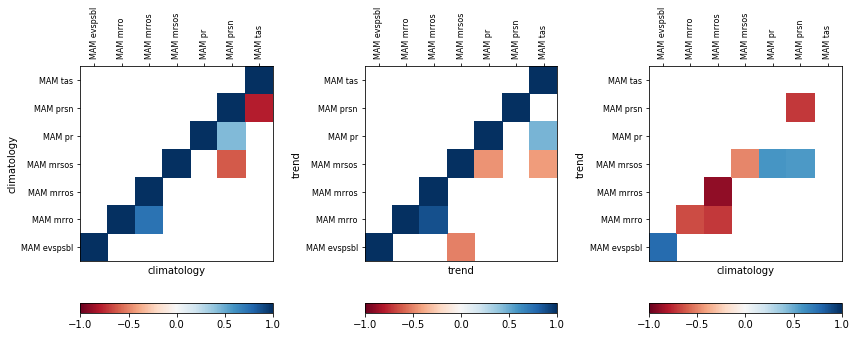

In [49]:
plot_correlations("GPu",significance_level=0.1,season="MAM")

# Lower great plains
The lower great plains provide a contrast with the region directly to the north, with no large changes in either surface or total runoff or precipitation.  Evaporation is projected to increase in the winter and decrease in the summer, and while surface soil moisture reductions are largest in winger, total soil moisture decreases throughout the year.

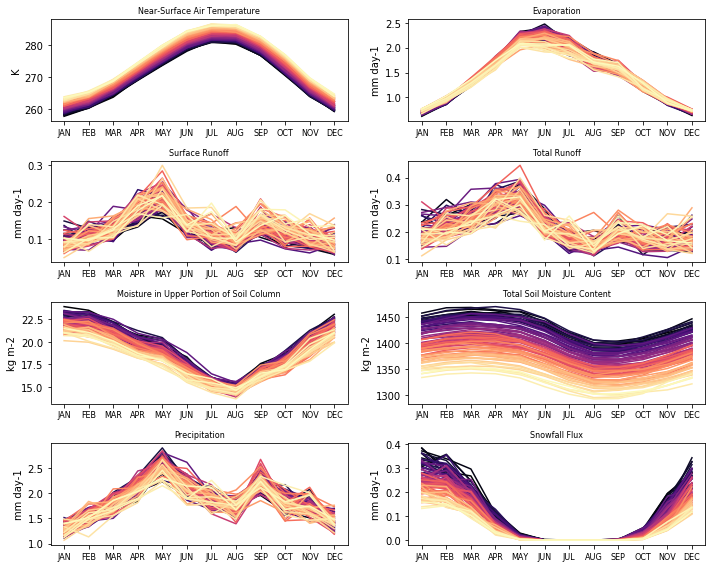

In [23]:
fig,axes=plot_variables("GPl")

There is very little model agreement in the sign or magnitude of most trends in this region.  While most models show winter increases in evaporation, trends throughout the year remain highly uncertain.  Most models project decresases in surface and total soil moisture throughout the year, but do not agree on the magnitude of the trends.  

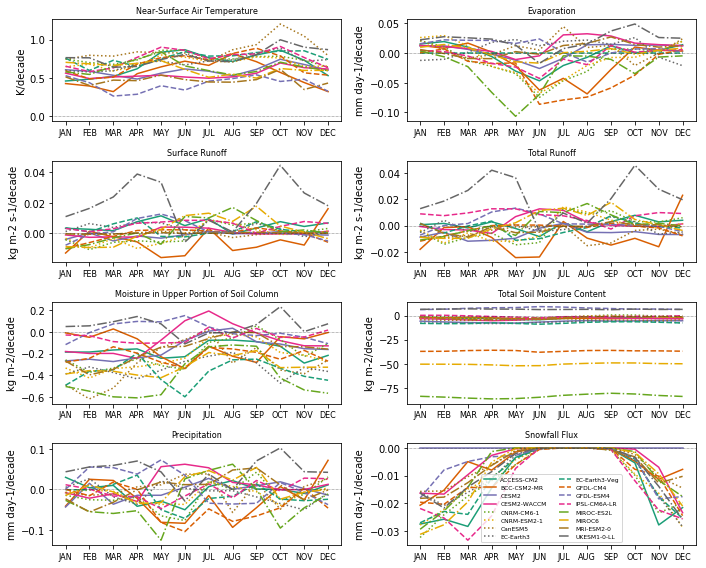

In [50]:
fig,axes=plot_models("GPl",change_units=False)

As suggested by Figure XX, models do not project the emergence of a forced signal at the "virtually certain" level by 2100 in any scenario.  The strongest signal of soil moisture appears in the wintertime, although it is projected (not shown) to be detectable before 2100 in MAM in all but the SSP1-2.6 scenario.  Total column springtime soil moisture changes are detectable only in the extreme SSP5-8.5 scenario. We note here that in contrast with many other regions, warming is strongest in fall, not summer.  

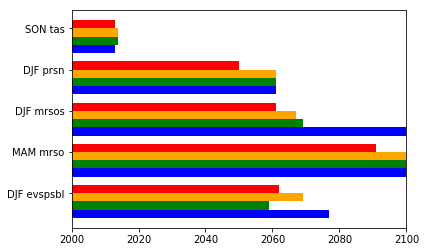

In [25]:
scenario_bar("GPl")

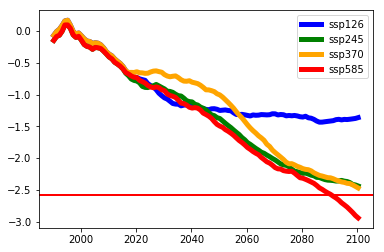

In [57]:
plot_all_scenarios("GPl","mrso","MAM")

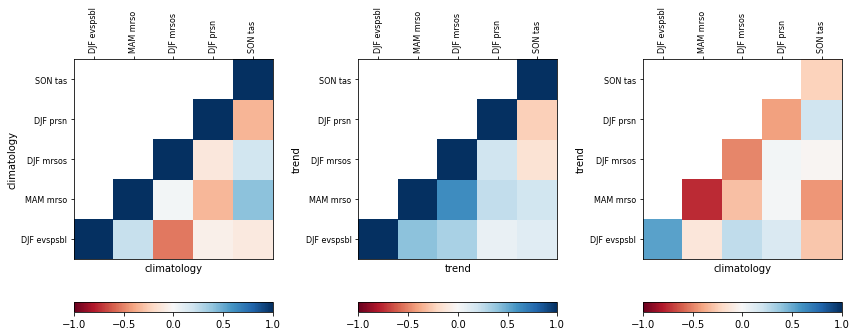

In [26]:
plot_correlations("GPl")

There are few robust relationships between variable climatologies and trends in this region.  Models in which the DJF evaporation climatology is large tend to have lower values of surface soil moisture in the same season (Figure XXa), and models with large springtime total soil moisture reductions have smaller reductions in wintertime surface soil moisture.  Interestingly, in contrast with the regions we have examined thus far, there is no strong correlation between surface soil moisture climatologies (in DJF, shown, or in MAM, not shown) or trends.

/Users/kmarvel/anaconda2/envs/cdatpy3/lib/python3.6/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/Users/kmarvel/anaconda2/envs/cdatpy3/lib/python3.6/site-packages/numpy/ma/core.py:3206: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mout = _mask[indx]


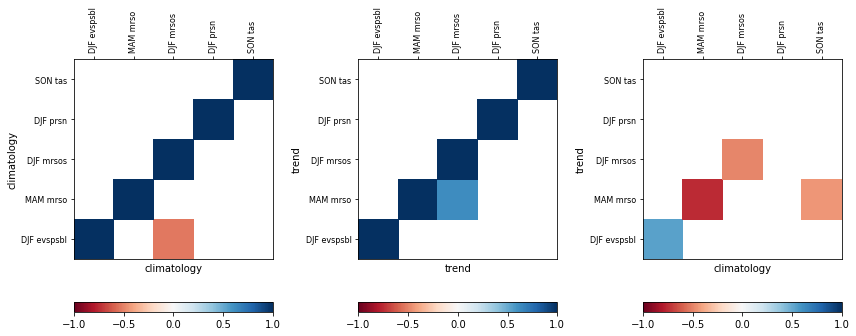

In [51]:
plot_correlations("GPl",significance_level=0.1)

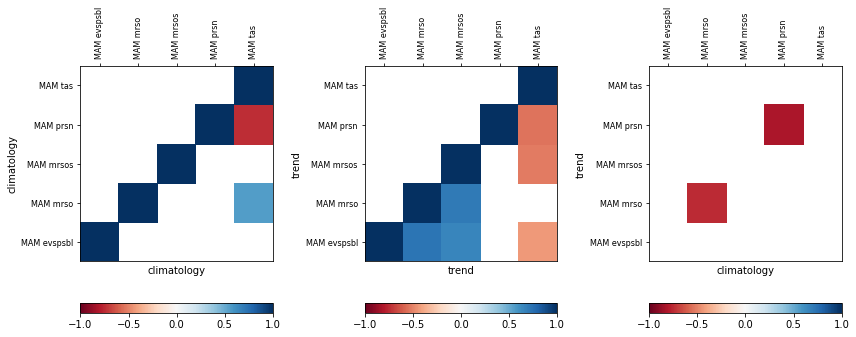

In [58]:
plot_correlations("GPl",significance_level=0.1,season="MAM")

# Midwest
In the Midwest, evaporation increases in winter and spring, with the peak of evaporation shifting earlier in the year.  Changes in surface and total runoff are small.  Surface soil moisture decreases throughout the year; total soil moisture decreases are largest in fall and winter. 

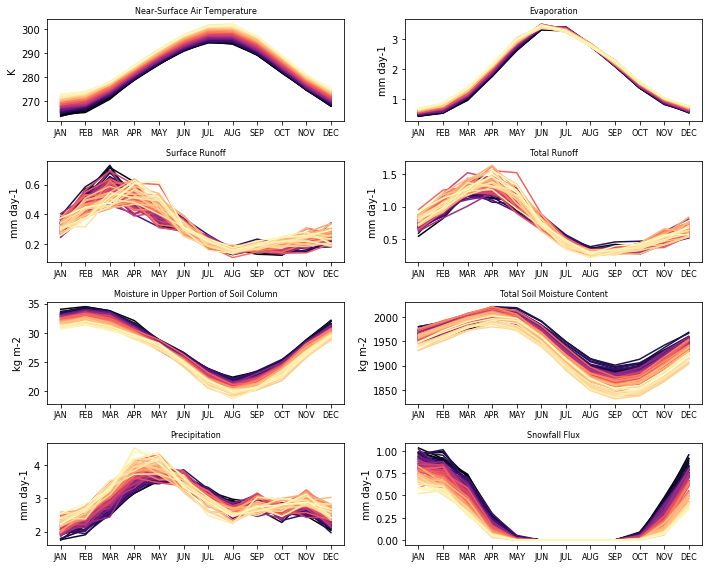

In [27]:
fig,axes=plot_variables("MW")

With one exception,  models project coherent increases in evaporation in the winter, fall, and spring; the magnitude and sign of summer trends remains uncertain.  The same is true for precipitation: every model projects increases outside the summer season.  Decreases in surface soil moisture are also robust across models.

/Users/kmarvel/anaconda2/envs/cdatpy3/lib/python3.6/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/Users/kmarvel/anaconda2/envs/cdatpy3/lib/python3.6/site-packages/numpy/ma/core.py:3206: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mout = _mask[indx]


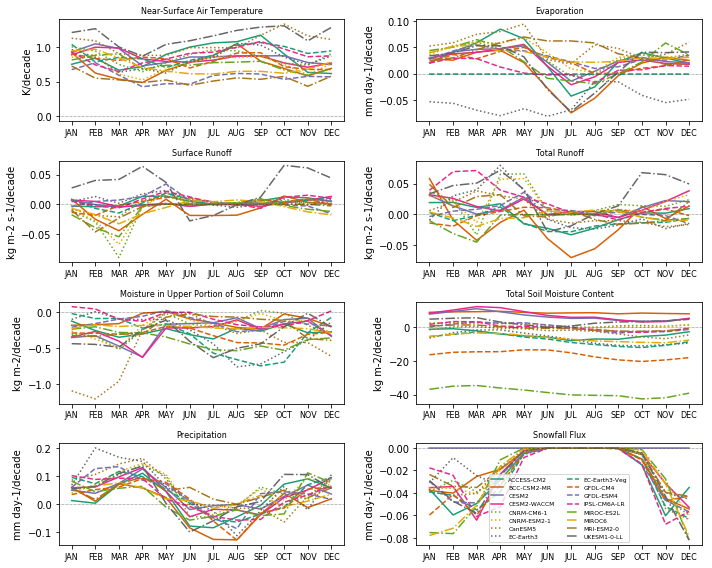

In [63]:
fig,axes=plot_models("MW")

Compared to the western regions, relatively few strong signals emerge in the Midwest.  The signals of wintertime reductions in surface soil moisture and increases in evaporation do not strongly depend on scenario, but wintertime precipitation increases are not detectable in the SSP1-2.6 scenario.

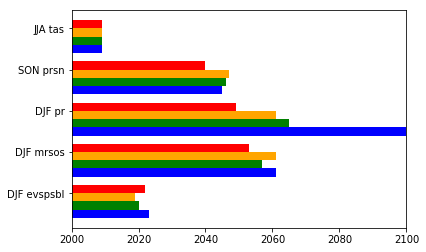

In [28]:
scenario_bar("MW")

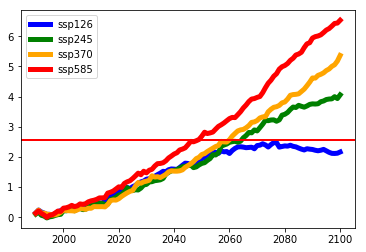

In [62]:
plot_all_scenarios("MW","pr","DJF")

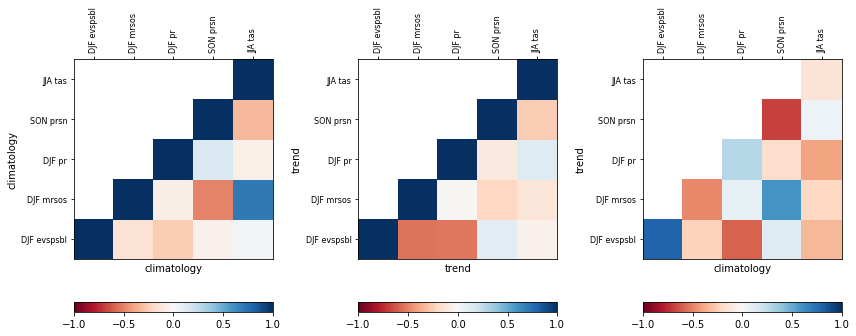

In [30]:
plot_correlations("MW")

In the midwest, models with large autumn snowfall totals tend to have smaller values of wintertime soil moisture; models with hot summers have larger wintertime soil moisture.  Trends in wintertime evaporation are inversely related to trends in wintertime precipitation and soil moisture, and while models that larger climatological values of DJF evaporation have larger evaporation increases in the future, models with smaller climatological DJF precipitation have smaller decreases.

/Users/kmarvel/anaconda2/envs/cdatpy3/lib/python3.6/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/Users/kmarvel/anaconda2/envs/cdatpy3/lib/python3.6/site-packages/numpy/ma/core.py:3206: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mout = _mask[indx]


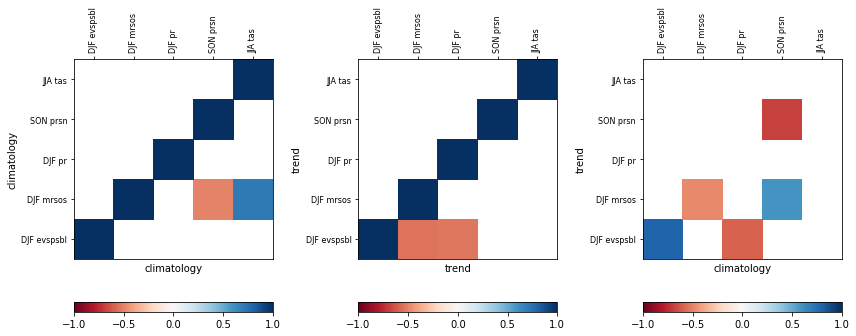

In [79]:
plot_correlations("MW",significance_level=0.1)

# Southeast
In the southeast, models project increases in winter and early spring precipitation, winter, spring, and fall evaporation, and decreases in summer surface soil moisture, as well as increases in surface and total runoff.  

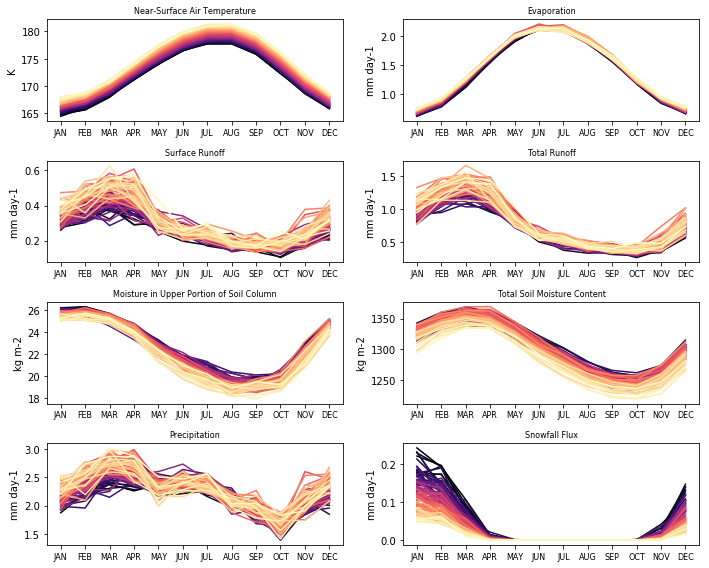

In [31]:
fig,axes=plot_variables("SE")

As for the Midwest, there is substantial model agreement in the sign (if not magnitude) of evaporation trends outside summer, and agreement in the sign of winter and early spring precipitation trends.

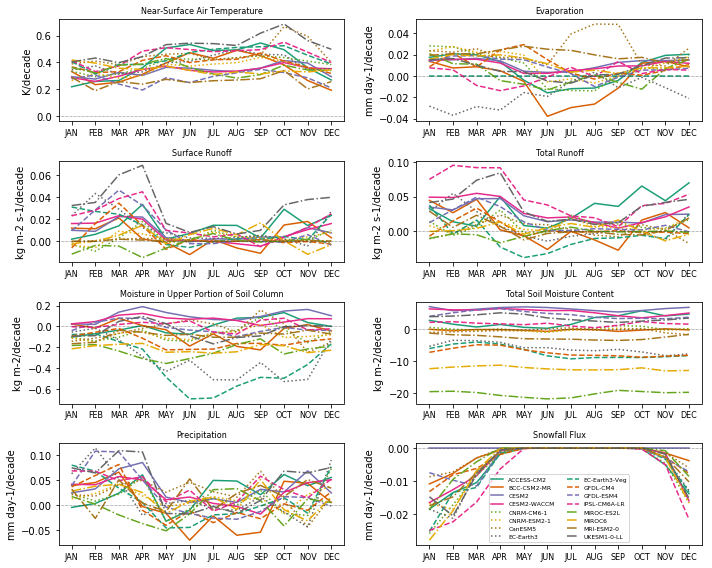

In [32]:
fig,axes=plot_models("SE")

A detectable increase in wintertime precipitation is expected to emerge above internal variability in two scenarios.  Because snowfall in this region is largely confined to the winter months, the signal of snowfall reduction is most apparent in DJF, not the spring or summer, as in other regions.  The signal of DJF surface soil moisture drying is detectable only in the SSP5-8.5 scenario; no signals of runoff change in any season emerge from the noise of internal variability in any scenario.

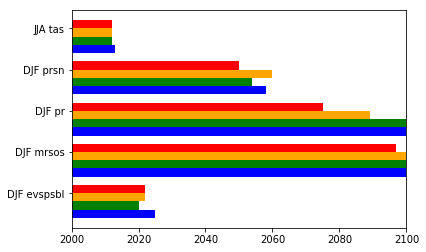

In [33]:
scenario_bar("SE")

/Users/kmarvel/anaconda2/envs/cdatpy3/lib/python3.6/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/Users/kmarvel/anaconda2/envs/cdatpy3/lib/python3.6/site-packages/numpy/ma/core.py:3206: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mout = _mask[indx]


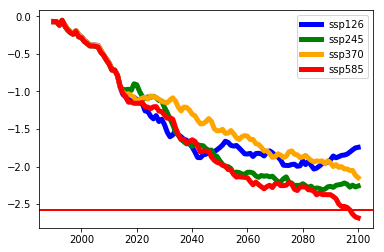

In [81]:
plot_all_scenarios("SE","mrsos","DJF")

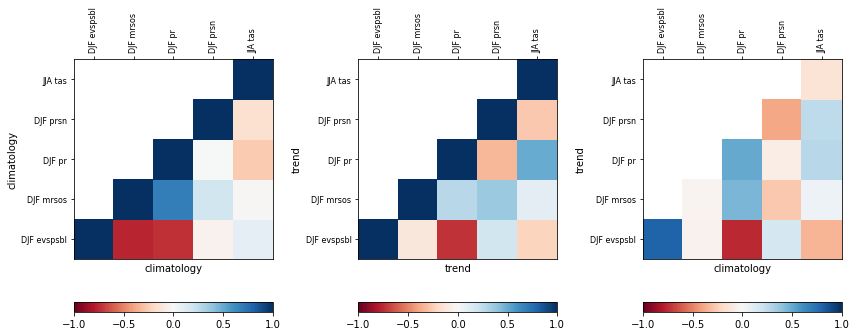

In [34]:
plot_correlations("SE")

/Users/kmarvel/anaconda2/envs/cdatpy3/lib/python3.6/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/Users/kmarvel/anaconda2/envs/cdatpy3/lib/python3.6/site-packages/numpy/ma/core.py:3206: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mout = _mask[indx]


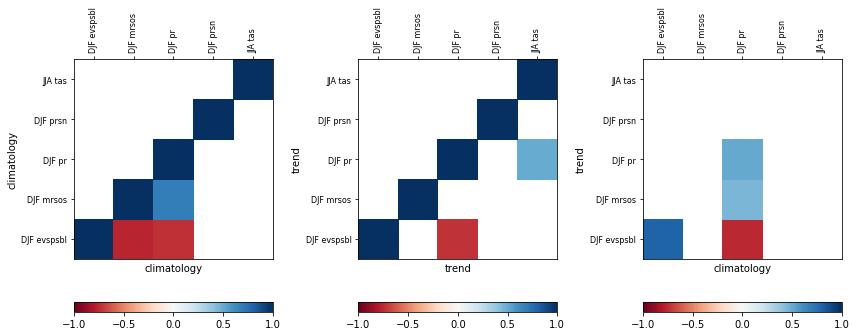

In [80]:
plot_correlations("SE",significance_level=0.1)

Wintertime precipitation and surface soil moisture climatologies are strongly inversly correlated with evaporation climatologies, and positivley correlated with each other.  Trends in wintertime evaporation and precipitation are also inversely related.  We note that unlike in the western regions, soil moisture and snowfall trends are not strongly correlated with the model climatological value, while total wintertime precipitation trends are strongly related to the climatological value.

# Northeast
In the Northeast, evaporation is projected to increase throughout the year.  Surface runoff sharply decreases in the spring, while total runoff increases over the same period.  While surface soil moisture decreases throughout the year, there is a pronounced shift in the seasonal cycle of total soil moisture, with increases in winter, early spring, and early fall, and little change in other months.  Precipitation increases in the winter and spring.  

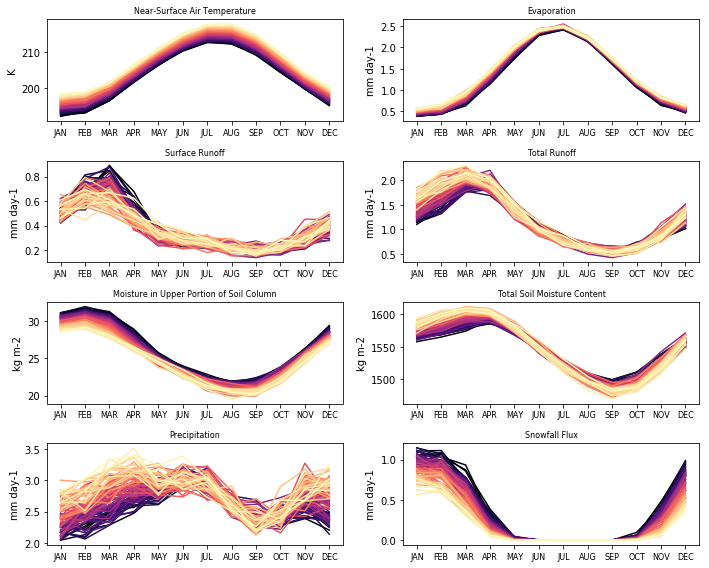

In [35]:
fig,axes=plot_variables("NE")

As in the midwest and southeast, models appear to agree on the sign of the evaporation trend outside the summer months, on the sign of total runoff changes in the winter, and on the seasonal cycle of precipitation changes.  Surface soil moisture also decreases in almost every model throughout the year.

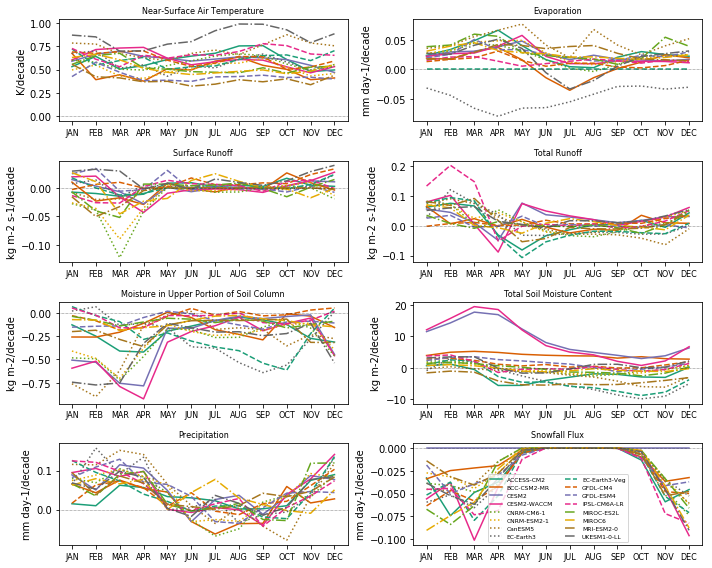

In [36]:
fig,axes=plot_models("NE")

Unlike in many other regions, springtime soil moisture reductions emerge relatively early, and emergence time does not appear dependent on scenario.  Also uniquely for this region, evaporation signals are strongest in summer, and are projected to already be detectable.  Despite model agreement in surface and total runoff trends, total runoff signals are detectable only in the two highest-emission scenarios, while models do not project a detectable surface runoff trend in any season for any scenario.

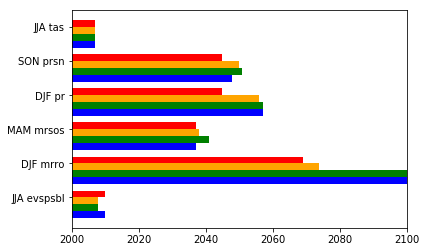

In [37]:
scenario_bar("NE")

/Users/kmarvel/anaconda2/envs/cdatpy3/lib/python3.6/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/Users/kmarvel/anaconda2/envs/cdatpy3/lib/python3.6/site-packages/numpy/ma/core.py:3206: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mout = _mask[indx]


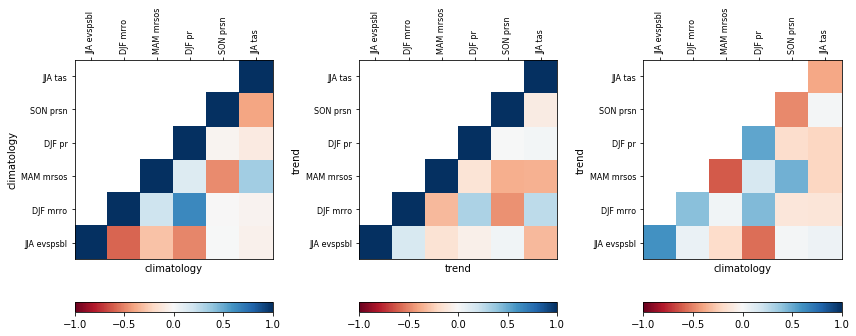

In [83]:
plot_correlations("NE")

/Users/kmarvel/anaconda2/envs/cdatpy3/lib/python3.6/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/Users/kmarvel/anaconda2/envs/cdatpy3/lib/python3.6/site-packages/numpy/ma/core.py:3206: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mout = _mask[indx]


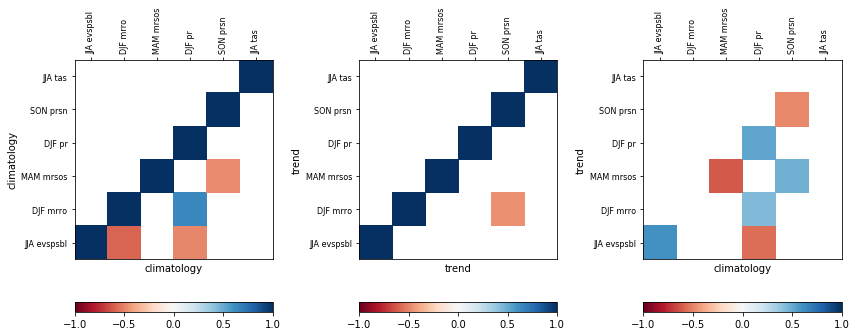

In [84]:
plot_correlations("NE",significance_level=0.1)

In [ ]:
redo_SN=False
if redo_SN:
    #REDO the S/N calculations
    #variables=["pr","evspsbl","mrro","mrros","mrso","mrsos","tas"]
    #variables=["mrsos","tas"]
    variables=['tas', 'mrro', 'mrros', 'mrso', 'mrsos', 'pr', 'evspsbl', 'prsn']


    seasons=["DJF","MAM","JJA","SON"]
    writedirec="/Volumes/MarvelCMIP6/DROUGHT/DroughtSN/"
    for variable in variables:
        for region in NCA4regions.keys():

            print(region)
            X=TOE(variable,region)
            for season in seasons:
                if np.abs(X.average_SN_end_century(season))>vcert:
                    print(season)
                    plt.figure()
                    SN=X.plot_signal_to_noise(season)
                    plt.title(region+ "("+season+")")
                    #plt.savefig(variable+"."+region+"."+season+".SN.png")
                    writehere=writedirec+region+"/"
                    os.system("mkdir "+writehere)
                    for ssp in SN.keys():
                        data=SN[ssp]
                        data.id=variable+"_SN"

                        writefname=variable+"."+ssp+"."+region+"."+season+".SN.nc"
                        fw=cdms.open(writehere+writefname,"w")
                        fw.write(data)
                        fw.close()






                    plt.clf()

In [ ]:
def noise_trend_correlation(region,variable,season,plot=False,L=10,return_corr=True):
    models=get_ok_models(region)
    symbols=np.repeat(np.array(["o","d","D","s","*","^","<",">","."]),2)
    self=TOE(variable,region)
    if season == "ANNUALCYCLE":
        L=L*12
    data=self.concatenate_piControl()
    cdutil.setTimeBoundsMonthly(data)
    seasdata=getattr(cdutil,season).departures(data)
    noiseterm=[]
    for model in seasdata:
        
        model.getAxis(0).id="time"

        noiseterm+=[np.std(bootstrap_slopes(model,L))]


    test=self.ensemble_average("ssp585")
    cdutil.setTimeBoundsMonthly(test)
    trends=cmip5.get_linear_trends(getattr(cdutil,season).departures(test))
    if plot:
        models=get_ok_models(region)
        for i in range(len(noiseterm)):
            plt.plot([noiseterm[i]],[trends.asma()[i]],marker=symbols[i],\
                     color=get_model_colors(models[i]),label=models[i])
            plt.xlabel("Noise term")
            plt.ylabel("Trend")
    if return_corr:
        return np.corrcoef(noiseterm,trends.asma())[0,1]
    else:
        return noiseterm,trends.asma()

In [ ]:
def plot_all_annual_cycles(variable,region,with_trends=False):
    X=TOE(variable, region)
    piC=X.concatenate_piControl()
    cdutil.setTimeBoundsMonthly(piC)
    piC_ac=cdutil.ANNUALCYCLE.climatology(piC)
    models=get_ok_models(region)
    
    if with_trends:
        ssp585=X.ensemble_average("ssp585")
        cdutil.setTimeBoundsMonthly(ssp585)
        acssp=cdutil.ANNUALCYCLE.departures(ssp585)
        MTrends=np.zeros((9,12))
        for mi in range(12):
            MTrends[:,mi]=cmip5.get_linear_trends(acssp[:,mi::12])
        iterstep=0
        for modeli in range(9):
            x=np.arange(12)+iterstep
            line,=plt.plot(x,piC_ac[modeli].asma(),color=get_model_colors(models[modeli]))
            #line.set_visible(False)
            for mi in range(12):
                y=piC_ac[modeli,mi]
                x=mi+iterstep
                dx=0
                dy=MTrends[modeli,mi]*10
                plt.arrow(x,y,dx,dy,color=get_model_colors(models[modeli]),\
                          width=.01,length_includes_head=True,\
                         head_width=0.1,alpha=.5)
            iterstep+=.1
    else:
        for i in range(len(models)):
            model=models[i]
            plt.plot(piC_ac[i].asma(),c=get_model_colors(models[i]),label=model)


        

In [ ]:
def check_out_correlation(region,variable,season,L=10):
    models=get_ok_models(region)
    plt.subplot(2,2,1)
    noiseterm,trends=noise_trend_correlation(region,variable,season,plot=True,return_corr=False,L=L)
    plt.legend(fontsize=6)
    plt.title("Noise vs trends")
    Rsq,pval=stats.pearsonr(trends,np.array(noiseterm))
    print("correlation is",np.round(Rsq,2))
    print("pval is",np.round(pval,3))
    plt.subplot(2,2,2)
    #Get piControl
    X=TOE(variable,region)
    Plotting.time_plot(X.concatenate_piControl(season))
    #Get climatologies
    plt.subplot(2,2,3)
    plot_all_annual_cycles(variable,region)
    #get seasonal means
    plt.subplot(2,2,4)
    piC=X.concatenate_piControl()
    cdutil.setTimeBoundsMonthly(piC)
    seasmean=getattr(cdutil,season).climatology(piC)[:,0]
    piC_seas=getattr(cdutil,season).departures(piC)
    for i in range(len(models)):
        plt.hist(bootstrap_slopes(piC_seas[i],L).asma(),color=get_model_colors(models[i]))
    Rsq,pval=stats.pearsonr(trends,seasmean)
    print("correlation between seasonal mean and trends is",np.round(Rsq,2))
    Rsq,pval=stats.pearsonr(noiseterm,seasmean)
    print("correlation between seasonal mean and noiseterm is",np.round(Rsq,2))
    return noiseterm,trends,seasmean

In [ ]:
def check_correlations(region):
    for variable in ['tas', 'mrro', 'mrros', 'mrso', 'mrsos', 'pr', 'evspsbl', 'prsn']:
        for season in ["DJF","MAM","JJA","SON"]:
            noiseterm,trends=noise_trend_correlation(region,variable,season,plot=False,return_corr=False)
            Rsq,pval=stats.pearsonr(trends,np.array(noiseterm))
            if pval<0.01:
                print(variable+" "+season)
                print("correlation is",np.round(Rsq,2))
                print("pval is",np.round(pval,3))

In [ ]:
check_correlations("SW")

In [ ]:
noiseterm,trends,seasmean=check_out_correlation("SW","mrsos","MAM")

In [ ]:
noiseterm,trends,seasmean=check_out_correlation("SW","prsn","MAM")

In [ ]:
noiseterm,trends,seasmean=check_out_correlation("NW","mrros","MAM")

In [ ]:
MRROS=TOE("mrros","NW")
piCtest=MRROS.concatenate_piControl()

In [ ]:
seasmean

In [ ]:
cdutil.setTimeBoundsMonthly(test)
ac_clim=cdutil.ANNUALCYCLE.climatology(test)

In [ ]:
[plt.plot(ac_clim[i].asma()) for i in [0,1,2,3,4,7,8]]

In [ ]:
np.argsort(trends)[:-2]

In [ ]:
Plotting.time_plot(test[5])

In [ ]:
SW_MRSO=TOE("mrso","SW")
Plotting.time_plot(SW_MRSO.concatenate_piControl("DJF"))

In [ ]:
sw_piC=SW_MRSO.concatenate_piControl()
cdutil.setTimeBoundsMonthly(sw_piC)
ac_sw=cdutil.ANNUALCYCLE.climatology(sw_piC)

In [ ]:
def plot_piC_ac(i):
    models=get_ok_models("NW")
    plt.plot(ac_sw[i].asma(),c=get_model_colors(models[i]),ls="-",label="Southwest")
    plt.plot(ac_clim[i].asma(),c=get_model_colors(models[i]),ls=":",label="NW")

In [ ]:
plot_piC_ac(5)
plot_piC_ac(1)

In [ ]:
def plot_all_annual_cycles(variable,region,with_trends=False):
    X=TOE(variable, region)
    piC=X.concatenate_piControl()
    cdutil.setTimeBoundsMonthly(piC)
    piC_ac=cdutil.ANNUALCYCLE.climatology(piC)
    models=get_ok_models(region)
    
    if with_trends:
        ssp585=X.ensemble_average("ssp585")
        cdutil.setTimeBoundsMonthly(ssp585)
        acssp=cdutil.ANNUALCYCLE.departures(ssp585)
        MTrends=np.zeros((9,12))
        for mi in range(12):
            MTrends[:,mi]=cmip5.get_linear_trends(acssp[:,mi::12])
        iterstep=0
        for modeli in range(9):
            x=np.arange(12)+iterstep
            line,=plt.plot(x,piC_ac[modeli].asma(),color=get_model_colors(models[modeli]))
            #line.set_visible(False)
            for mi in range(12):
                y=piC_ac[modeli,mi]
                x=mi+iterstep
                dx=0
                dy=MTrends[modeli,mi]*10
                plt.arrow(x,y,dx,dy,color=get_model_colors(models[modeli]),\
                          width=.01,length_includes_head=True,\
                         head_width=0.1,alpha=.5)
            iterstep+=.1
    else:
        for i in range(len(models)):
            model=models[i]
            plt.plot(piC_ac[i].asma(),c=get_model_colors(models[i]),label=model)


        

In [ ]:
plot_all_annual_cycles("mrsos","SW",with_trends=True)

In [ ]:
plot_all_annual_cycles("pr","MW",with_trends=True)


In [ ]:
X=TOE("mrsos","SW")
ssp585=X.ensemble_average("ssp585")
piC=X.concatenate_piControl()
cdutil.setTimeBoundsMonthly(piC)
piC_ac=cdutil.ANNUALCYCLE.climatology(piC)


In [ ]:
NW_pr=TOE("pr","NW")
Plotting.time_plot(NW_pr.concatenate_piControl("DJF"))

In [ ]:
cdutil.setTimeBoundsMonthly(ssp585)
acssp=cdutil.ANNUALCYCLE.departures(ssp585)

In [ ]:
d=set_up_axis()
for region in NCA4regions.keys():
    ax=d[region]
    scenario_bar(region,ax=ax)
    ax.set_title(region)
    plt.tight_layout()

In [ ]:
plot_all_scenarios("SE","mrsos","DJF")